In [32]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from scipy.spatial import distance
    
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler
   
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# Load data

## Base

### Base dataset

In [2]:
df_base = pd.read_csv(r'C:\\Users\\Admin\\Desktop\\data\\base.csv')#, index_col=0)"../data/base.csv", index_col=0)
df_base.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [3]:
df_base.shape

(2918139, 73)

In [4]:
def ind(row):
        r = int(row['Id'][:-5])
        return r
df_base['Id'] = df_base.apply(ind, axis = 1)
df_base = df_base.set_index('Id')   

### Create index

In [5]:
dims = df_base.shape[1]
n_cells = 100
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [6]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [7]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

#del df_base

In [72]:
base_index[2918138]

4744766

# Train

In [8]:
df_train = pd.read_csv(r'C:\\Users\\Admin\\Desktop\\data\\train.csv')#, index_col=0)"
df_train.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [9]:
def i_id(row):
    r = int(row['Id'][:-6])
    return r
df_train['Id'] = df_train.apply(i_id, axis = 1)
df_train = df_train.set_index('Id')

In [10]:
def indt(row):
    r = int(row['Target'][:-5])
    return r
df_train['Target'] = df_train.apply(indt, axis = 1)

In [11]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [12]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

In [13]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

7.726


In [14]:
train_target = df_base.loc[targets.tolist()]
train_target.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
675816,-63.856552,17.163416,-32.269220,-169.75210,198.870730,-77.228960,-347.360606,13.288679,108.231070,43.82885,...,-107.259094,80.318184,-151.78957,56.448963,66.886116,45.391710,40.096794,116.982010,-415.750254,-18.195980
366656,-88.614190,4.574929,-22.700304,-144.94324,80.877815,-92.111590,-530.528109,-18.696142,114.099470,163.91055,...,-77.159775,12.424929,-162.74518,85.860939,70.269700,-15.091993,48.642250,101.123980,-1074.464888,-71.665270
1447819,-68.748230,3.549367,-126.559456,-169.50517,195.694610,-52.882294,26.943937,-23.964437,119.211330,227.63394,...,-51.152130,94.640840,-176.32103,119.981731,66.266970,17.248710,170.587340,131.261600,-1074.464888,-33.020058
1472602,-50.560276,6.856050,-116.298416,-134.44357,65.365280,-127.862350,-775.150134,93.207756,125.221085,269.04950,...,-56.015300,41.230500,-136.19551,7.052096,64.016380,97.340790,54.679436,118.847440,-903.069010,3.276848
717819,-79.635185,14.442431,-58.904266,-147.05140,57.131943,-16.240410,-321.317964,45.992638,125.942150,103.38858,...,-68.775360,45.028675,-196.09872,-117.626337,66.926575,42.453735,77.619740,92.482574,-1074.464888,-21.129560


In [15]:
train_target.reset_index(inplace = True, drop = True)

In [16]:
df = df_train.subtract(train_target)

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.973804,0.808020,-9.847884,-14.18458,-11.353240,-9.915970,0.000000,25.018923,0.854490,-13.415337,17.65196,-4.909415,9.188588,-8.299217,-29.160560,7.650337,-1.681485,14.320800,41.435470,0.741140,-5.949920,-608.794347,2.329120,5.449740,-13.436054,0.000000,18.144910,-1.333481,6.526640,-0.50178,1.218312,23.50643,-0.906479,-147.689343,20.658486,13.912800,8.246464,-1.18731,9.270500,-3.032119,4.219903,-0.375276,8.493250,21.610940,-2.644514,-6.716680,-6.388740,-32.937700,-14.635979,14.387470,78.803045,-17.252650,-11.746425,7.550490,4.834846,10.602560,4.326650,-8.554220,12.484870,25.033116,-9.273140,3.945190,1.831274,-10.210824,-4.013000,-158.414906,-0.982326,-10.934210,22.545300,17.781590,0.000000,-7.762592
1,0.837820,2.231339,-9.354242,-32.31715,39.925515,8.301000,435.955360,-59.736948,10.816430,-23.579480,-58.47786,-32.540016,-11.472810,-42.237022,-83.360766,-12.917353,-9.282306,-30.272327,-23.966550,-0.514660,12.983536,-1154.073533,-49.516798,-64.414810,-4.650162,0.000000,29.663030,11.978475,-89.463046,-5.65640,46.090540,123.82439,-29.402640,-66.036464,-10.858173,18.650446,10.447355,12.24939,-4.785700,24.937083,-7.666535,6.378327,81.653770,53.503355,0.000000,-23.400206,-87.479076,12.954290,-5.314813,16.933727,0.277230,11.435517,9.967560,-66.443548,-9.139745,-16.895149,-2.870330,62.231726,-96.701720,-261.608494,12.213959,-5.268480,36.347542,-7.755751,11.047470,-87.499642,-2.098824,40.188184,41.332726,29.465650,39.372677,20.388437
2,18.768665,0.292119,10.440866,-10.89681,-5.566180,2.044674,0.000000,-6.483052,6.559834,-16.026120,12.40713,21.705564,12.041309,-20.311700,-2.842910,6.351206,12.398163,9.150508,1.701350,0.835795,9.089900,1032.528661,-29.356591,-21.678970,7.475302,0.000000,41.968418,1.254036,-46.212878,6.93217,-3.903997,8.44394,4.685710,-647.640314,-22.635051,10.756040,12.964758,-0.36599,1.751230,5.516310,-8.454816,1.204787,26.887333,12.558960,0.000000,15.808784,-19.413835,12.923480,7.091072,-44.527649,-21.821150,28.519044,8.407754,20.416460,4.330070,2.210765,3.713080,-14.705517,-2.292250,176.218651,39.167550,6.092970,-0.879532,-16.601076,7.174830,-37.837545,-0.258750,1.151786,41.822390,-9.330130,0.000000,10.472880
3,2.749714,2.230548,0.896721,13.43221,29.287560,18.606940,0.000000,-14.021236,-1.217985,-26.398850,22.37575,-19.615450,9.819559,19.270248,-21.621345,5.803643,-5.119036,20.919907,-18.955860,-0.162756,-1.189345,0.000000,-25.494072,11.742787,-15.051719,0.000000,-32.877540,1.265267,4.973373,-4.17338,-9.375837,6.53159,-10.890793,-536.882589,10.301226,-12.408005,16.093509,0.93821,2.300670,1.100313,-2.472664,-0.451387,28.195240,4.514416,0.000000,-16.508760,-60.164532,-15.083060,31.466667,-16.493390,-28.206650,-5.204946,-5.431513,-14.545710,0.066440,-5.493855,2.716060,14.216540,5.787040,-312.230044,-51.405895,-4.088450,-5.551747,3.284766,-9.221240,86.938885,0.114970,8.721130,28.499324,-0.569715,-171.395878,-23.179636
4,0.003059,0.000455,0.000869,-0.00114,-0.004875,0.000881,0.000000,-0.007962,-0.000866,0.004090,-0.00213,0.016609,0.002047,-0.001509,0.004930,-0.000431,0.000680,0.012909,0.009960,-0.000110,-0.003685,0.000000,-0.018807,0.001720,-0.000152,0.000000,0.004225,0.000986,-0.005851,0.00041,-0.000358,-0.00121,-0.003350,-591.488889,-0.000555,-0.004356,0.000859,-0.00043,0.000320,-0.000488,-0.000399,-0.000143,-0.003010,-0.012920,0.000000,-0.008724,0.003260,-0.010193,0.013824,-0.000624,0.009443,-0.016375,-0.001770,-0.000180,-0.001345,0.000870,0.000960,-0.003900,-0.001258,-154.549676,-0.007830,0.000326,0.004760,0.000235,0.006650,0.000000,-0.000355,0.002435,0.002025,-0.002644,0.000000,-0.019791
5,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [20]:
def dis(row):
    e = 0
    for i in row:
        e = e +i**2
    return e**0.5
df['tar'] = df.apply(dis, axis = 1)
target_train = df['tar']

In [21]:
model_cat = CatBoostRegressor()

In [22]:
model_cat.fit(df_train, target_train)

Learning rate set to 0.084758
0:	learn: 362.4372956	total: 293ms	remaining: 4m 53s
1:	learn: 358.5428512	total: 414ms	remaining: 3m 26s
2:	learn: 354.7863307	total: 517ms	remaining: 2m 51s
3:	learn: 351.7196449	total: 628ms	remaining: 2m 36s
4:	learn: 348.3965066	total: 724ms	remaining: 2m 24s
5:	learn: 345.4440750	total: 845ms	remaining: 2m 20s
6:	learn: 343.2072570	total: 970ms	remaining: 2m 17s
7:	learn: 341.2217630	total: 1.07s	remaining: 2m 13s
8:	learn: 338.9114158	total: 1.18s	remaining: 2m 10s
9:	learn: 336.8368189	total: 1.35s	remaining: 2m 13s
10:	learn: 335.2531699	total: 1.45s	remaining: 2m 10s
11:	learn: 334.2235613	total: 1.54s	remaining: 2m 7s
12:	learn: 333.2101749	total: 1.65s	remaining: 2m 5s
13:	learn: 332.3347848	total: 1.74s	remaining: 2m 2s
14:	learn: 331.4867604	total: 1.85s	remaining: 2m 1s
15:	learn: 330.6497610	total: 1.98s	remaining: 2m 1s
16:	learn: 329.8781792	total: 2.07s	remaining: 1m 59s
17:	learn: 329.2756119	total: 2.16s	remaining: 1m 57s
18:	learn: 32

151:	learn: 310.8389914	total: 19.9s	remaining: 1m 51s
152:	learn: 310.7938887	total: 20s	remaining: 1m 50s
153:	learn: 310.7407890	total: 20.2s	remaining: 1m 50s
154:	learn: 310.6579559	total: 20.3s	remaining: 1m 50s
155:	learn: 310.5880593	total: 20.5s	remaining: 1m 50s
156:	learn: 310.5037751	total: 20.6s	remaining: 1m 50s
157:	learn: 310.4631905	total: 20.8s	remaining: 1m 50s
158:	learn: 310.4266381	total: 20.9s	remaining: 1m 50s
159:	learn: 310.3603099	total: 21s	remaining: 1m 50s
160:	learn: 310.3121935	total: 21.1s	remaining: 1m 50s
161:	learn: 310.2732798	total: 21.2s	remaining: 1m 49s
162:	learn: 310.1478963	total: 21.4s	remaining: 1m 49s
163:	learn: 310.0969439	total: 21.5s	remaining: 1m 49s
164:	learn: 309.9472099	total: 21.7s	remaining: 1m 49s
165:	learn: 309.8047325	total: 21.9s	remaining: 1m 49s
166:	learn: 309.7627042	total: 22s	remaining: 1m 49s
167:	learn: 309.7226501	total: 22.1s	remaining: 1m 49s
168:	learn: 309.6810802	total: 22.2s	remaining: 1m 49s
169:	learn: 309.

302:	learn: 303.0860850	total: 41.5s	remaining: 1m 35s
303:	learn: 303.0538808	total: 41.6s	remaining: 1m 35s
304:	learn: 303.0122107	total: 41.7s	remaining: 1m 35s
305:	learn: 302.9651194	total: 41.9s	remaining: 1m 34s
306:	learn: 302.9195549	total: 42s	remaining: 1m 34s
307:	learn: 302.8885394	total: 42.2s	remaining: 1m 34s
308:	learn: 302.8557638	total: 42.3s	remaining: 1m 34s
309:	learn: 302.8108893	total: 42.4s	remaining: 1m 34s
310:	learn: 302.7657299	total: 42.6s	remaining: 1m 34s
311:	learn: 302.7198294	total: 42.7s	remaining: 1m 34s
312:	learn: 302.6911696	total: 42.8s	remaining: 1m 33s
313:	learn: 302.6513710	total: 42.9s	remaining: 1m 33s
314:	learn: 302.6182475	total: 43.1s	remaining: 1m 33s
315:	learn: 302.5816598	total: 43.2s	remaining: 1m 33s
316:	learn: 302.5389202	total: 43.3s	remaining: 1m 33s
317:	learn: 302.5143253	total: 43.5s	remaining: 1m 33s
318:	learn: 302.4567164	total: 43.6s	remaining: 1m 33s
319:	learn: 302.4199735	total: 43.7s	remaining: 1m 32s
320:	learn: 

453:	learn: 297.2440747	total: 1m 2s	remaining: 1m 15s
454:	learn: 297.2138937	total: 1m 2s	remaining: 1m 15s
455:	learn: 297.1882036	total: 1m 2s	remaining: 1m 14s
456:	learn: 297.1561468	total: 1m 2s	remaining: 1m 14s
457:	learn: 297.1087515	total: 1m 3s	remaining: 1m 14s
458:	learn: 297.0567378	total: 1m 3s	remaining: 1m 14s
459:	learn: 297.0314281	total: 1m 3s	remaining: 1m 14s
460:	learn: 296.9988761	total: 1m 3s	remaining: 1m 14s
461:	learn: 296.9737890	total: 1m 3s	remaining: 1m 14s
462:	learn: 296.9462103	total: 1m 3s	remaining: 1m 13s
463:	learn: 296.9117675	total: 1m 3s	remaining: 1m 13s
464:	learn: 296.8792494	total: 1m 4s	remaining: 1m 13s
465:	learn: 296.8478879	total: 1m 4s	remaining: 1m 13s
466:	learn: 296.8185847	total: 1m 4s	remaining: 1m 13s
467:	learn: 296.7785069	total: 1m 4s	remaining: 1m 13s
468:	learn: 296.7355513	total: 1m 4s	remaining: 1m 13s
469:	learn: 296.7028978	total: 1m 4s	remaining: 1m 12s
470:	learn: 296.6711030	total: 1m 4s	remaining: 1m 12s
471:	learn

604:	learn: 291.9281339	total: 1m 23s	remaining: 54.8s
605:	learn: 291.8844404	total: 1m 24s	remaining: 54.6s
606:	learn: 291.8599033	total: 1m 24s	remaining: 54.5s
607:	learn: 291.8291197	total: 1m 24s	remaining: 54.3s
608:	learn: 291.7951909	total: 1m 24s	remaining: 54.2s
609:	learn: 291.7616873	total: 1m 24s	remaining: 54.1s
610:	learn: 291.7281887	total: 1m 24s	remaining: 53.9s
611:	learn: 291.6886638	total: 1m 24s	remaining: 53.8s
612:	learn: 291.6573877	total: 1m 24s	remaining: 53.6s
613:	learn: 291.6358713	total: 1m 25s	remaining: 53.5s
614:	learn: 291.6090387	total: 1m 25s	remaining: 53.4s
615:	learn: 291.5754515	total: 1m 25s	remaining: 53.2s
616:	learn: 291.5389374	total: 1m 25s	remaining: 53s
617:	learn: 291.5040750	total: 1m 25s	remaining: 52.9s
618:	learn: 291.4738112	total: 1m 25s	remaining: 52.8s
619:	learn: 291.4310022	total: 1m 25s	remaining: 52.6s
620:	learn: 291.3911557	total: 1m 26s	remaining: 52.5s
621:	learn: 291.3550330	total: 1m 26s	remaining: 52.4s
622:	learn: 

755:	learn: 286.8622633	total: 1m 45s	remaining: 34s
756:	learn: 286.8359719	total: 1m 45s	remaining: 33.8s
757:	learn: 286.8087806	total: 1m 45s	remaining: 33.7s
758:	learn: 286.7802964	total: 1m 45s	remaining: 33.6s
759:	learn: 286.7498707	total: 1m 45s	remaining: 33.5s
760:	learn: 286.7172528	total: 1m 46s	remaining: 33.4s
761:	learn: 286.6861491	total: 1m 46s	remaining: 33.2s
762:	learn: 286.6614344	total: 1m 46s	remaining: 33.1s
763:	learn: 286.6257687	total: 1m 46s	remaining: 32.9s
764:	learn: 286.5963173	total: 1m 46s	remaining: 32.8s
765:	learn: 286.5802739	total: 1m 46s	remaining: 32.6s
766:	learn: 286.5569984	total: 1m 46s	remaining: 32.5s
767:	learn: 286.5161767	total: 1m 47s	remaining: 32.4s
768:	learn: 286.4787210	total: 1m 47s	remaining: 32.2s
769:	learn: 286.4548324	total: 1m 47s	remaining: 32.1s
770:	learn: 286.4316726	total: 1m 47s	remaining: 31.9s
771:	learn: 286.3964481	total: 1m 47s	remaining: 31.8s
772:	learn: 286.3691829	total: 1m 47s	remaining: 31.7s
773:	learn: 

906:	learn: 282.2625867	total: 2m 6s	remaining: 13s
907:	learn: 282.2341534	total: 2m 6s	remaining: 12.8s
908:	learn: 282.1968175	total: 2m 6s	remaining: 12.7s
909:	learn: 282.1737585	total: 2m 6s	remaining: 12.5s
910:	learn: 282.1414034	total: 2m 6s	remaining: 12.4s
911:	learn: 282.1117071	total: 2m 7s	remaining: 12.3s
912:	learn: 282.0789517	total: 2m 7s	remaining: 12.1s
913:	learn: 282.0429984	total: 2m 7s	remaining: 12s
914:	learn: 282.0198159	total: 2m 7s	remaining: 11.9s
915:	learn: 281.9897170	total: 2m 7s	remaining: 11.7s
916:	learn: 281.9712040	total: 2m 7s	remaining: 11.6s
917:	learn: 281.9329953	total: 2m 8s	remaining: 11.4s
918:	learn: 281.8982124	total: 2m 8s	remaining: 11.3s
919:	learn: 281.8511427	total: 2m 8s	remaining: 11.2s
920:	learn: 281.8132531	total: 2m 8s	remaining: 11s
921:	learn: 281.7823160	total: 2m 8s	remaining: 10.9s
922:	learn: 281.7584983	total: 2m 9s	remaining: 10.8s
923:	learn: 281.7284538	total: 2m 9s	remaining: 10.6s
924:	learn: 281.6897563	total: 2m 

In [23]:
df_valid = pd.read_csv(r'C:\\Users\\Admin\\Desktop\\data\\validation.csv')#, index_col=0)\n",
df_valid['Id'] = df_valid.apply(i_id, axis = 1)
df_valid = df_valid.set_index('Id')
df_valid.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255370,44.165030,-135.29533,-19.5

In [ ]:
df_v.hist(bins=30, figsize = (100,100))

In [ ]:
df['tar'].hist(bins = 30, figsize = (19,5))

In [ ]:
df_v['tar'].hist(bins = 30, figsize = (19,5))

In [24]:
predictions_cat = model_cat.predict(df_valid)

In [34]:
validation_answer = pd.read_csv(r'C:\\Users\\Admin\\Desktop\\data\\validation_answer.csv')#, index_col=0)\n",
validation_answer.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


In [35]:
#validation_answer['Expected'].tolist()

In [36]:
def i_ans(row):
    r = int(row['Expected'][:-5])
    return r
validation_answer['Expected'] = validation_answer.apply(i_ans, axis = 1)   

In [37]:
train_valid = df_base.loc[validation_answer['Expected'].tolist()]
#train_valid

In [38]:
train_valid.reset_index(inplace = True, drop = True)
df_valid.reset_index(inplace = True, drop = True)

In [39]:
df_v = df_valid.subtract(train_valid)

In [42]:
df_v['tar'] = df_v.apply(dis, axis = 1)
target_valid = df_v['tar']

In [43]:
target_valid

0        1814.684699
1        1968.536563
2         487.767800
3        2072.813426
4         815.278158
            ...     
99995    2118.108800
99996    1407.567902
99997    1881.016653
99998     456.292532
99999     512.675016
Name: tar, Length: 100000, dtype: float64

<Axes: >

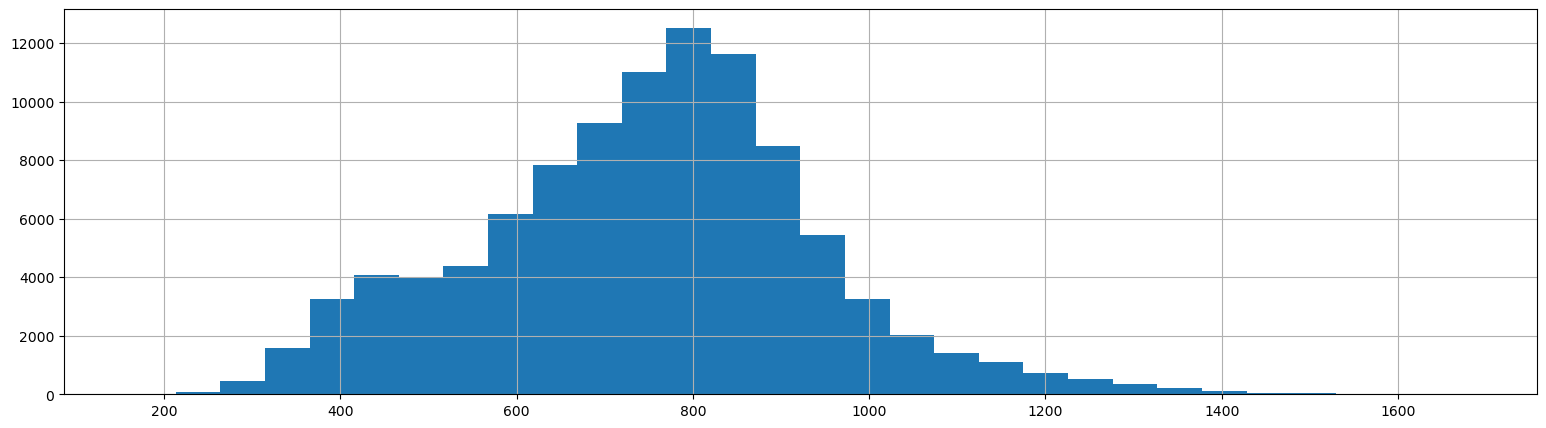

In [41]:
pd.Series(predictions_cat).hist(bins = 30, figsize = (19,5))

In [ ]:
#pd.Series(predictions).hist(bins = 30, figsize = (19,5))

<Axes: >

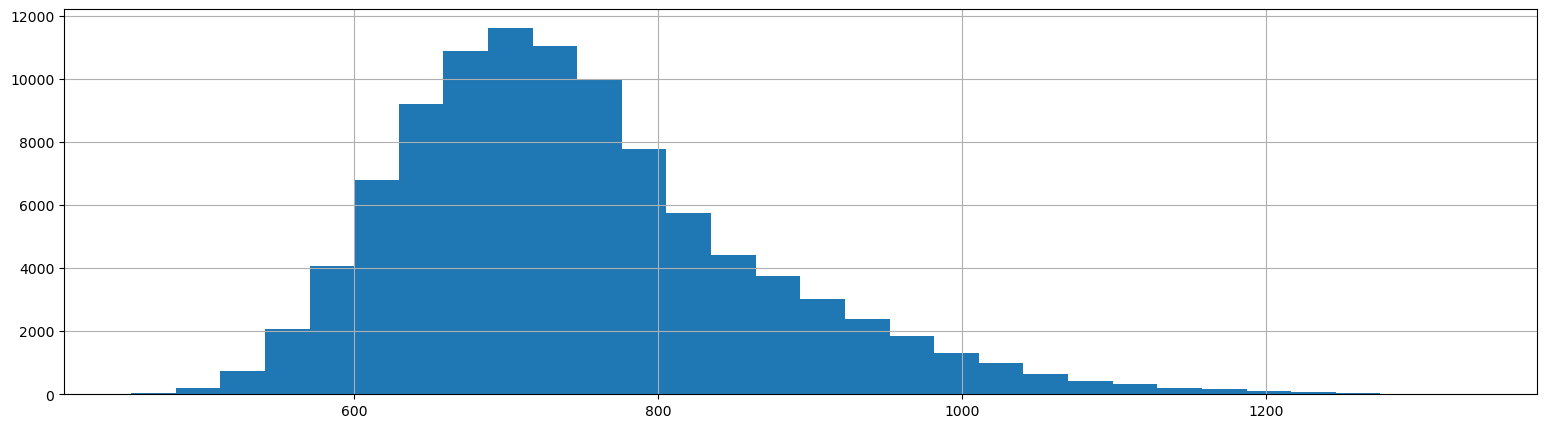

In [33]:
pd.Series(predictions_log).hist(bins = 30, figsize = (19,5))

In [44]:
result = mean_squared_error(target_valid, predictions_cat)**0.5
result

540.6727656030944

In [28]:
#a = df_valid[:1].values
#b = df_base.loc[[2676668]].values
   
#di = ((b - a)**2).sum(axis=1)**0.5\n
#di

In [29]:
model_log = LinearRegression()
model_log.fit(df_train, target_train)
predictions_log = model_log.predict(df_valid)
predictions_log[:10]

array([ 942.93996627,  969.76445114,  568.41465239, 1059.99513139,
        965.69481537,  934.9133041 ,  786.78912165,  893.56211505,
        707.80359127, 1011.07230274])

In [45]:
result_log = mean_squared_error(target_valid, predictions_log)**0.5
result_log

583.6760190786088

Поиск ближайших соседей

In [58]:
df.hist(bins=30, figsize = (100,100))

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>],
       [<Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>,
        <Axes: title={'center': '13'}>, <Axes: title={'center': '14'}>,
        <Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>],
       [<Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
        <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
        <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>,
        <Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
        <Axes: title={'center': '26'}>],
       [<Axes: title={'

In [ ]:
df_train['tr'] = None

In [97]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,tr
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.082690,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.841370,-78.512180,-94.428940,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.730790,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.991640,-31.948470,82.314430,-115.830470,-243.309390,6.622036,-132.197660,68.712560,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.386170,-105.427820,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,[675816]
1,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.605800,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267030,-78.659430,-92.761490,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.124150,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.150900,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061080,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.411360,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,[]
2,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.346560,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.505680,-78.372925,-69.324480,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.801120,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.639530,-30.211614,48.527400,-122.406640,-112.713620,53.461838,-31.117260,107.841510,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.223070,-52.031662,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,[1447819]
3,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.517070,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789320,-78.737090,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.228930,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.958370,-30.800995,123.623400,-37.540867,-72.139800,71.240990,-168.115590,118.236450,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.198290,-61.567047,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,[1472602]
4,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.153020,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.554630,-79.066610,-77.926460,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.560770,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.184970,-53.147078,79.869446,-151.131350,-45.056160,79.796234,46.763016,47.681810,-24.1

In [ ]:
for i in range(100000):    
    dd = df_base[(df_base['6']==df_train['6'][i])] #) & (df_base['6']<(df_train['6'][0]+1))]
    x = dd.index.tolist()
    df_train['tr'][i] = x #i_d.append(dd.index)
    #print(x)
    if i ==100:
        break

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][i] = x #i_d.append(dd.index)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15040\452750802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tr'][

In [95]:
x.tolist()

[2381316]

In [80]:
d_i

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
675816,-63.856552,17.163416,-32.26922,-169.7521,198.87073,-77.22896,-347.360606,13.288679,108.23107,43.82885,-105.73465,-47.786125,-36.88103,13.17214,227.50856,-37.725586,-2.122084,-150.13141,-203.27684,-79.25332,-88.47902,1507.231274,-72.46964,72.97062,121.46883,813.770071,-92.93579,13.943903,-190.34848,150.21762,-28.260628,-156.7186,107.327225,-156.24989,28.072304,44.272907,16.004486,-150.03679,-113.552765,-31.460691,-16.806957,2.998167,-129.46317,128.3807,-29.303956,89.03111,-109.44173,-210.37169,21.258015,-146.58513,-10.090485,-21.554174,74.68386,-140.20494,84.35418,76.43722,-125.60653,1.567287,-218.99869,4.452471,-67.75645,-136.33136,-107.259094,80.318184,-151.78957,56.448963,66.886116,45.39171,40.096794,116.98201,-415.750254,-18.19598


In [76]:
#for i in ['6','70']:    
dd = df_base[(df_base['6']>(df_train['6'][0]-1)) & (df_base['6']<(df_train['6'][0]+1))]
dd = dd[(dd['70']>(df_train['70'][0]-1)) & (dd['70']<(df_train['70'][0]+1))]
#dd = df_base[(df_base[]>(df_train[i][1]-1)) & (df_base[i]<(df_train[i][1]+1))]    

In [77]:
dd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
675816,-63.856552,17.163416,-32.269220,-169.752100,198.87073,-77.228960,-347.360606,13.288679,108.231070,43.828850,-105.73465,-47.786125,-36.881030,13.172140,227.508560,-37.725586,-2.122084,-150.131410,-203.27684,-79.253320,-88.479020,1507.231274,-72.469640,72.970620,121.468830,813.770071,-92.935790,13.943903,-190.348480,150.21762,-28.260628,-156.71860,107.327225,-156.249890,28.072304,44.272907,16.004486,-150.03679,-113.552765,-31.460691,-16.806957,2.998167,-129.463170,128.38070,-29.303956,89.031110,-109.441730,-210.37169,21.258015,-146.585130,-10.090485,-21.554174,74.683860,-140.204940,84.354180,76.437220,-125.60653,1.567287,-218.998690,4.452471,-67.756450,-136.33136,-107.259094,80.318184,-151.789570,56.448963,66.886116,45.391710,40.096794,116.98201,-415.750254,-18.195980
1503984,-71.961560,13.024012,-40.174720,-120.757600,123.32381,-63.483498,-347.643091,-43.819800,136.159060,45.594162,-164.18180,-55.774475,6.001358,-25.322020,100.134430,-16.187218,-2.301443,-2.177261,-100.09755,-79.574776,-118.865430,1507.231274,-77.381670,74.979490,-49.214070,813.770071,-5.702183,16.843616,-93.401596,150.08888,-23.862396,-157.92943,104.524400,-771.296708,56.925964,94.654236,27.150623,-148.82756,-125.682270,-55.116238,-4.258582,0.680957,-154.300080,149.46538,-23.869516,20.152573,-133.361300,-141.19731,-27.261951,47.677040,76.660830,-0.372690,85.134840,-116.176750,86.162964,67.870300,-132.45384,-6.972100,-159.904460,-162.306259,-52.283850,-134.28561,-56.726920,29.813293,-97.128815,136.369071,68.550080,-44.745030,136.862120,128.80312,-414.838126,7.832863
1813416,-25.538593,2.269808,-28.286330,-138.404300,129.50922,-79.830220,-346.994582,-51.641890,116.272736,40.909775,-191.18835,-19.853035,29.173695,34.659134,183.774400,-6.435863,3.564986,-3.113484,-197.83302,-79.279730,-94.804670,1507.231274,19.091053,71.945305,30.690586,813.770071,-142.519070,5.186482,-39.084244,159.09734,-18.969597,-180.54507,83.185180,-282.600919,12.026300,93.822790,17.605972,-158.92352,-127.844154,-37.507797,-11.562475,2.811233,-124.567990,148.70633,-62.396355,71.621500,-5.019592,-144.42044,28.197908,-23.087711,24.619160,-21.004300,75.541780,-121.540070,83.586334,55.636105,-149.74965,-4.997294,-57.264114,-663.910687,-140.146030,-124.79724,-89.267784,0.939663,-121.820390,5.795765,72.298880,-10.264627,-32.741554,101.92498,-416.220857,-16.977577
2797353,-100.866910,16.588728,-17.113688,-145.172420,130.56903,-38.873116,-347.269044,52.364674,122.569370,123.116080,-242.10358,-55.065080,-14.618843,73.248170,113.011765,-3.951120,12.175548,-49.545532,-118.62145,-79.980430,-122.441220,1507.231274,-72.700940,60.368557,32.873985,813.770071,-46.255380,15.557342,-69.426056,140.94011,36.378155,-143.51964,58.978530,-537.183707,-2.190269,122.927630,-71.438760,-149.72418,-128.359420,-46.648620,-12.698398,1.498538,-196.402250,67.91628,-18.251750,75.804230,-60.585800,-148.07867,85.294390,23.147709,37.931010,-35.341496,70.288850,-106.912980,87.217540,68.645380,-130.09825,-38.439663,-165.714390,-293.217178,-95.864235,-143.89044,-93.445305,-49.412950,-162.948000,60.966521,67.969850,-4.218163,141.445220,130.55860,-416.152619,-93.699455
3316087,-107.505035,13.016945,-52.900013,-153.763230,100.33544,-43.515842,-348.283311,-18.472284,125.809975,81.808820,-202.39423,-74.477540,-87.102830,12.875741,116.349210,-9.172939,21.636112,-76.832120,-120.60309,-79.459250,-134.806720,1507.231274,-54.259026,81.302840,14.970176,813.770071,-28.472470,17.355110,-84.614440,134.38649,27.476799,-154.18849,61.113500,-537.183707,16.704872,120.553345,-36.320160,-148.64189,-127.690450,-37.028152,-16.845396,3.291272,-197.710800,66.04156,-18.251750,117.714190,-66.475300,-92.16699,111.581750,-26.047432,51.633415,0.529369,69.085760,-132.934140,87.6

In [78]:
df[df['6']==0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,tar
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.973804,0.808020,-9.847884,-14.184580,-11.353240,-9.915970,0.0,25.018923,0.854490,-13.415337,17.651960,-4.909415,9.188588,-8.299217,-29.160560,7.650337,-1.681485,14.320800,41.435470,0.741140,-5.949920,-608.794347,2.329120,5.449740,-13.436054,0.0,18.144910,-1.333481,6.526640,-0.50178,1.218312,23.50643,-0.906479,-147.689343,20.658486,13.912800,8.246464,-1.18731,9.27050,-3.032119,4.219903,-0.375276,8.493250,21.610940,-2.644514,-6.716680,-6.388740,-32.937700,-14.635979,14.387470,78.803045,-17.252650,-11.746425,7.55049,4.834846,10.602560,4.32665,-8.554220,12.484870,25.033116,-9.273140,3.945190,1.831274,-10.210824,-4.013000,-158.414906,-0.982326,-10.934210,22.545300,17.781590,0.000000,-7.762592,659.816267
2,18.768665,0.292119,10.440866,-10.896810,-5.566180,2.044674,0.0,-6.483052,6.559834,-16.026120,12.407130,21.705564,12.041309,-20.311700,-2.842910,6.351206,12.398163,9.150508,1.701350,0.835795,9.089900,1032.528661,-29.356591,-21.678970,7.475302,0.0,41.968418,1.254036,-46.212878,6.93217,-3.903997,8.44394,4.685710,-647.640314,-22.635051,10.756040,12.964758,-0.36599,1.75123,5.516310,-8.454816,1.204787,26.887333,12.558960,0.000000,15.808784,-19.413835,12.923480,7.091072,-44.527649,-21.821150,28.519044,8.407754,20.41646,4.330070,2.210765,3.71308,-14.705517,-2.292250,176.218651,39.167550,6.092970,-0.879532,-16.601076,7.174830,-37.837545,-0.258750,1.151786,41.822390,-9.330130,0.000000,10.472880,1239.550393
3,2.749714,2.230548,0.896721,13.432210,29.287560,18.606940,0.0,-14.021236,-1.217985,-26.398850,22.375750,-19.615450,9.819559,19.270248,-21.621345,5.803643,-5.119036,20.919907,-18.955860,-0.162756,-1.189345,0.000000,-25.494072,11.742787,-15.051719,0.0,-32.877540,1.265267,4.973373,-4.17338,-9.375837,6.53159,-10.890793,-536.882589,10.301226,-12.408005,16.093509,0.93821,2.30067,1.100313,-2.472664,-0.451387,28.195240,4.514416,0.000000,-16.508760,-60.164532,-15.083060,31.466667,-16.493390,-28.206650,-5.204946,-5.431513,-14.54571,0.066440,-5.493855,2.71606,14.216540,5.787040,-312.230044,-51.405895,-4.088450,-5.551747,3.284766,-9.221240,86.938885,0.114970,8.721130,28.499324,-0.569715,-171.395878,-23.179636,665.059614
4,0.003059,0.000455,0.000869,-0.001140,-0.004875,0.000881,0.0,-0.007962,-0.000866,0.004090,-0.002130,0.016609,0.002047,-0.001509,0.004930,-0.000431,0.000680,0.012909,0.009960,-0.000110,-0.003685,0.000000,-0.018807,0.001720,-0.000152,0.0,0.004225,0.000986,-0.005851,0.00041,-0.000358,-0.00121,-0.003350,-591.488889,-0.000555,-0.004356,0.000859,-0.00043,0.00032,-0.000488,-0.000399,-0.000143,-0.003010,-0.012920,0.000000,-0.008724,0.003260,-0.010193,0.013824,-0.000624,0.009443,-0.016375,-0.001770,-0.00018,-0.001345,0.000870,0.00096,-0.003900,-0.001258,-154.549676,-0.007830,0.000326,0.004760,0.000235,0.006650,0.000000,-0.000355,0.002435,0.002025,-0.002644,0.000000,-0.019791,611.346637
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,520.635211,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,22.877973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,521.137626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [61]:
for i in df['25'][:100]:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
276.4675696577022
0.0
0.0
638.1743629182948
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-364.56220056025415
-846.9470179687117
0.0
0.0
-115.38814998173109
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-13.565101337354278
0.0
0.0
0.0
0.0
-132.5267983788494
0.0
-177.13307319767512
0.0
0.0
0.0
332.2486913136745
0.0
444.7064015503804
0.0
-449.8823477437152
226.25562107615957
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-573.7465574181332
690.8253270810908
421.838985715188
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-164.65708023658794
377.17124131496865
0.0
0.0
0.0
0.0
0.0
0.0
49.01095682904122
0.0
0.0
0.0
428.94898223329926
121.6262253038459
0.0
0.0


In [31]:
numeric = df_train.columns
scaler_1 = RobustScaler()
df_train[numeric] = scaler_1.fit_transform(df_train[numeric])
df_valid[numeric] = scaler_1.transform(df_valid[numeric])
#df_train_s

NameError: name 'df_train_st' is not defined

In [ ]:
model_cat_st = CatBoostRegressor()
model_cat_st.fit(df_train_s, target_train)
predictions_cat_st = model_cat_st.predict(df_valid_s)
predictions_cat_st[:10]